45.0
2.678748096012425
419541.294537463 0.019526322854107825 20
266465.01014611847 0.011612301497979427 21
108721.90704350616 0.003786695246905225 22
52959.78774298914 0.006050979833055248 23
52959.78774298914 0.006050979833055248 23
12279.948470194126 0.005477605291577703 22.75
12279.948470194126 0.005477605291577703 22.75
1874.5612184901256 0.005329559855180577 22.6875
1874.5612184901256 0.005329559855180577 22.6875
488.42835831525736 0.005297561017999719 22.671875
Final ground value is  2.6987480960124244 and final z angle is 22.671875
Vinkelforskjellen ble  0.019999999999999574  radianer, eller  1.145915590261622  grader.
-0.86627449823359 0.06158249303947249
Estimated length: 1660462.1148082018 meters.
Estimated maximum height: 186138.32178729493 meters.
Estimated time of flight: funky_t, or  459.0 seconds.


<IPython.core.display.Javascript object>


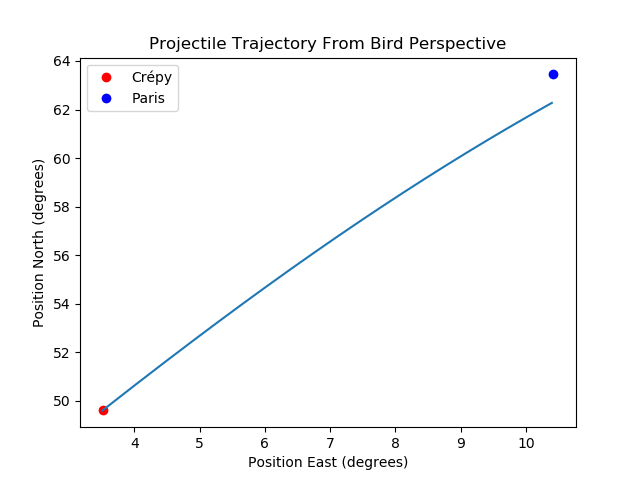

<IPython.core.display.Javascript object>


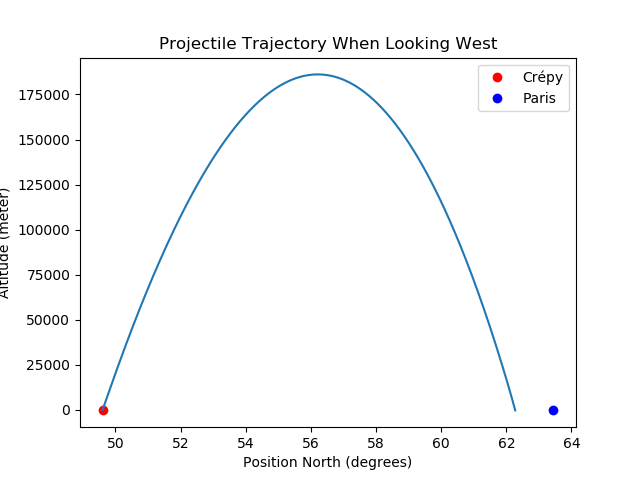

<IPython.core.display.Javascript object>


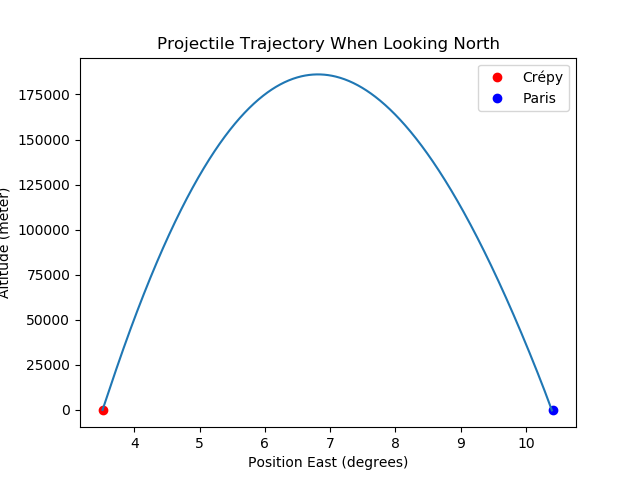

<IPython.core.display.Javascript object>


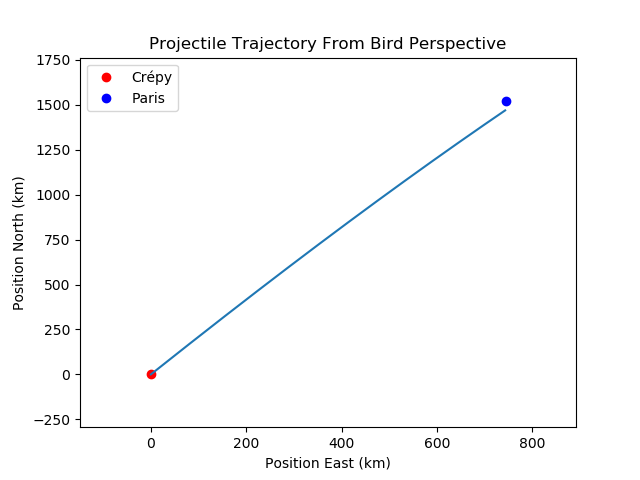

C:\Users\Fredrik Knapskog\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:509: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Fredrik Knapskog\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:510: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


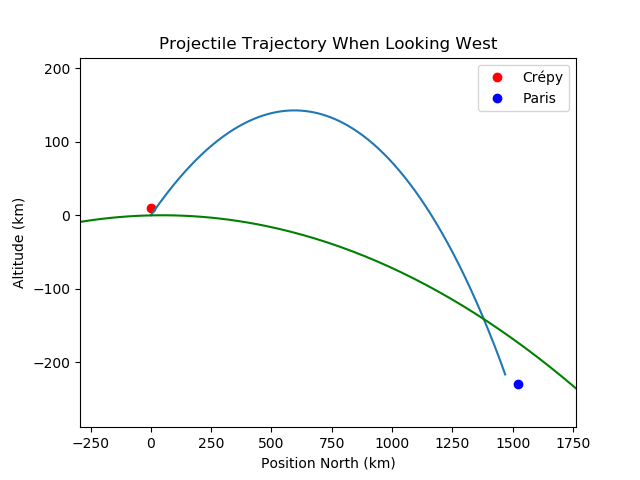

C:\Users\Fredrik Knapskog\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:523: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Fredrik Knapskog\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:524: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


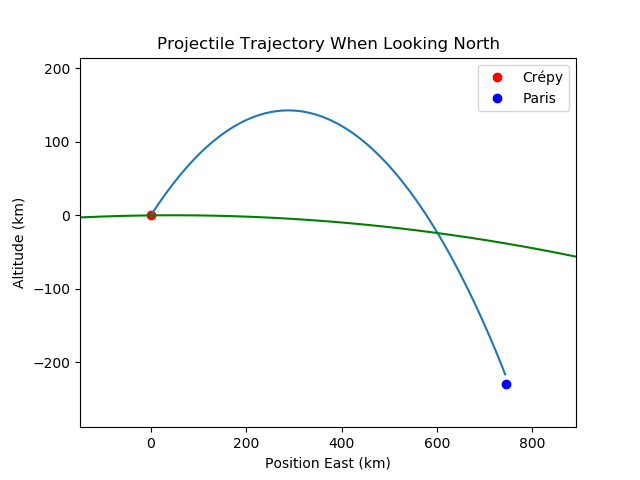

C:\Users\Fredrik Knapskog\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:537: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Fredrik Knapskog\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:538: RuntimeWarning: invalid value encountered in sqrt


In [7]:
%matplotlib notebook
import numpy as np
import copy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

g=-9.81
B_0=0.5*4*10**(-5)
#B_0 = 0.2*0.0366*0.5
y_0=10**4
a=6.5*10**(-3)
alpha=2.5
T_0=290
m=106
omega=7.29*10**(-5) #jordens rotasjonshastighet
R = 6371000
G = 5.972*10**(24)*6.67*10**(-11)

#start = [0,0,0,0,0,0]
start=np.array([-49,-36,-18,3,30,53]) #Crépy
#end=np.array([-48,-51,-24,2,21,3]) #Paris
#end = np.array([48, 51, 24, -177, -30, -53]) #Pacific ocean
end = np.array([-63, -26, -48, 10, 25, 18]) #Trondheim
#end = np.array([-59, -54, -40, 10, 44, 0]) #Oslo
#end = np.array([-78, 0, 0, 16, 0, 0]) #Svalbard

#Funksjon for å beregne vinkel mellom startpunkt og sluttpunkt (ingen korioliseffekt).
#0 radianer tilsvarer å skyte rett sørover.
#Den tar inn to arrays med hhv posisjon nord og øst.
# x-sør, y-øst

def gradianer(vek1, vek2):
    if len(vek1) != len(vek2):
        print("Skalarprodukterror")
        return 0
    lengde = len(vek1)
    lengde1=0
    lengde2=0
    skalarprodukt = 0
    for i in range(lengde):
        lengde1+=vek1[i]**2
        lengde2+=vek2[i]**2
        skalarprodukt += vek1[i]*vek2[i]
    return np.arccos(skalarprodukt/np.sqrt(lengde1*lengde2))

print(gradianer([1,0],[np.sqrt(2)/2, np.sqrt(2)/2])*180/np.pi)

def direction(start_loc, end_loc):
    x_end=end_loc[0]+end_loc[1]/60+end_loc[2]/3600
    x_start=start_loc[0]+start_loc[1]/60+start_loc[2]/3600
    y_end=end_loc[3]+end_loc[4]/60+end_loc[5]/3600
    y_start=start_loc[3]+start_loc[4]/60+start_loc[5]/3600
    
    endradx = x_end*np.pi/180
    startradx = x_start*np.pi/180
    endrady = y_end*np.pi/180
    startrady = y_start*np.pi/180
 
    """
    z_end= np.sqrt(R**2-(x_end-x_start)**2 -(y_end-y_start)**2)
    lamda_rad=-x_start*np.pi/180
    bamba_rad= y_start*np.pi/180
    x_comp=x_end-x_start
    y_comp=y_end-y_start
    #part 2
    x1_start=x_start*2*np.pi*R/360
    y1_start=y_start*2*np.pi*R/360
    z1_start = np.sqrt(R**2-x1_start**2-y1_start**2)
    x_end=(end_loc[0]+end_loc[1]/60+end_loc[2]/3600)*2*np.pi*R/360
    y_end=(end_loc[3]+end_loc[4]/60+end_loc[5]/3600)*2*np.pi*R/360
    z_end= np.sqrt(R**2-(x_end-x1_start)**2 -(y_end-y1_start)**2)
    length = np.sqrt((x_end-x1_start)**2+(y_end-y1_start)**2+(z_end-R)**2)
    print("Starts at",-x_start,",",y_start, "and ends at",-x_end,",",y_end)
    """
    
    x1_start=x_start*2*np.pi*R/360
    y1_start=y_start*2*np.pi*R/360
    phi_start = 0
    theta_start = 0
    phi_slutt = (x_end-x_start)*np.pi/180
    theta_slutt = (y_end-y_start)*np.pi/180
    
    length = np.sqrt(2*(R**2)*(1-np.cos(startradx)*np.cos(endradx) - np.sin(startradx)*np.sin(endradx)*np.cos(theta_slutt)))
    
    y_slutt = R*np.sin(theta_slutt)*np.cos(phi_slutt)
    x_slutt = R*np.sin(phi_slutt)
    reis_vec = [R*np.sin(phi_slutt), R*np.cos(phi_slutt)*np.sin(theta_slutt), R*np.cos(phi_slutt)*np.cos(theta_slutt)]
    reis_deg = [0, 0, R]
    #start_vec = [R*np.sin(startradx), R*np.sin(startrady)*np.cos(startradx), R*np.cos(startrady)*np.cos(startradx)]
    #slutt_vec = [R*np.sin(endradx), R*np.sin(endrady)*np.cos(endradx), R*np.cos(endrady)*np.cos(endradx)]
    mainphi = gradianer(reis_vec, reis_deg)
    #print(mainphi)
    x_comp=x_end-x_start
    y_comp=y_end-y_start
    ga = np.arctan(y_comp/x_comp)
    if np.sign(y_comp*x_comp)==1:
        if x_comp > 0:
            ga+=np.pi
    if np.sign(y_comp*x_comp)==-1:
        if x_comp < 0:
            ga+=np.pi
    lamda_rad=-x_start*np.pi/180
    z_end = R*(np.cos(mainphi)-1)
    #length = np.sqrt((reis_vec[0]-reis_deg[0])**2+(reis_vec[1]-reis_deg[1])**2+(reis_vec[2]-reis_deg[2])**2)
    #length = 2*R*np.sin(mainphi*0.5)
    #print(lenstart, lenend, R)
    #print(x1_start, x_slutt, y1_start, y_slutt, z_end, length)
    
    return ga, lamda_rad, x_end, y_end, z_end, length, -1*x_start, y_start, x_slutt, y_slutt
ground_angle, lamda_rad, x_end, y_end, z_end, length, x_start, y_start, x_slutt, y_slutt =direction(start,end)
#print("Direction:",ground_angle, "radians.")

def rotasjonsmatriseshit2(beta, gamma, x, y, z):
    z+= R
    beta*=np.pi/180
    gamma*=-np.pi/180
    x1 = np.cos(beta)*x + np.sin(beta)*np.sin(gamma)*y + np.sin(beta)*np.cos(gamma)*z
    x2 = np.cos(gamma)*y - np.sin(gamma)*z
    x3 = -np.sin(beta)*x + np.sin(gamma)*np.cos(beta)*y + np.cos(beta)*np.cos(gamma)*z
    øst = gradianer([x2, x3], [0, 1])
    sør = gradianer([x1, x3], [0, 1])
    print(sør*180/np.pi, øst*180/np.pi)
    return øst, sør
       
def rotasjonsmatriseshit(beta, gamma, x, y, z):
    z+= R
    beta*=np.pi/180
    gamma*=-np.pi/180
    x1 = (1+np.cos(beta))*x + np.sin(beta)*z
    x2 = (1+np.cos(gamma))*y - np.sin(gamma)*z
    x3 = -np.sin(beta)*x + np.sin(gamma)*y + (np.cos(beta)+np.cos(gamma))*z
    øst = gradianer([x2, x3], [0, 1])
    sør = gradianer([x1, x3], [0, 1])
    print(sør*180*2/np.pi, øst*180*2/np.pi)
    return øst, sør

def rotasjonsør(beta, x, y, z):
    z+= R
    beta*=np.pi/180
    x1 = np.cos(beta)*x + np.sin(beta)*z
    x2 = y
    x3 = -np.sin(beta)*x + np.cos(beta)*z
    sør = np.arctan(x1/np.sqrt(x2**2+x3**2))
    #print(sør*180/np.pi)
    return sør

def rotasjonøst(gamma, x, y, z):
    z+= R
    gamma*=-np.pi/180
    x1 = x
    x2 = np.cos(gamma)*y - np.sin(gamma)*z
    x3 = np.sin(gamma)*y + np.cos(gamma)*z
    øst = np.arctan(x2/x3)
    #print(øst*180/np.pi)
    return øst

"""
rotasjonsmatriseshit(25, 30, 0, 0, 0)
rotasjonsmatriseshit2(25, 30, 0, 0, 0)
rotasjonsør(25, 0, 0, 0)
rotasjonøst(30, 0, 0, 0)
print(fakkk)
"""

def graviradi(south, east, up, x_0, y_0, z_0):
    return np.sqrt((south-x_0)**2 + (east-y_0)**2 + (up+R-z_0)**2)
    
def grafs(radi, radii):
    return G*radii/(radi**3)

#Startet med å kopiere de adiabatiske utregningene fra prosjekt 1.
#Første endring blir å skrive om y til z og dekomponere x i y og x. 
#Deretter implementere korioliseffekten.
    
def general_part(z, v_x, v_y, v_z):
    must_be_positive=1-a*z/T_0
    if must_be_positive<0:
        return 0
    if z < 0:
        return 0
    return B_0*(must_be_positive**alpha)*np.sqrt(v_x**2+v_y**2+v_z**2)

def a_adi(product, v_q):
    return -1*product*v_q

def k_adiabatic(w,angle, x_0, y_0, z_0):
    radi = graviradi(w[0],w[1],w[2], x_0, y_0, z_0)
    cop=copy.copy(w)
    cop[0]=w[3]
    cop[1]=w[4]
    cop[2]=w[5]
    B_V_product=general_part(radi-R, w[3], w[4], w[5])

    cop[3]=-1*grafs(radi, w[0]-x_0) + a_adi(B_V_product,w[3])+2*w[4]*omega*np.sin(angle)
    cop[4]=-1*grafs(radi, w[1]-y_0) + a_adi(B_V_product,w[4])-2*(w[3]*np.sin(angle)+w[5]*np.cos(angle))*omega
    cop[5]=-1*grafs(radi, w[2]+R - z_0) + a_adi(B_V_product,w[5])+2*w[4]*omega*np.cos(angle)
#    print(w[0], w[1], w[2])
#    print(w[4]*omega*np.cos(angle)*2)
    return cop

def f(w,h,angle, x_0, y_0, z_0):
    k1=k_adiabatic(w,angle, x_0, y_0, z_0)
    k2=k_adiabatic(w+h/2*k1,angle, x_0, y_0, z_0)
    k3=k_adiabatic(w+h/2*k2,angle, x_0, y_0, z_0)
    k4=k_adiabatic(w+h*k3,angle, x_0, y_0, z_0)
    return w+h/6*(k1+2*k2+2*k3+k4)

def Lengde(x1, y1, z1, x0, y0, z0):
    return np.sqrt((z1-z0)**2+(y1-y0)**2+(x1-x0)**2)

def numerical_algorithm(direction, z_angle, lamda, v_0, start_pos, h):
    teller = 0
    z_angle*=(np.pi/180)
    beta=(start_pos[0]+start_pos[1]/60+start_pos[2]/3600)
    gamma=(start_pos[3]+start_pos[4]/60+start_pos[5]/3600)
    #x_0=R*np.sin(x_0_0*np.pi/180)
    #y_0=R*np.sin(x_0_0*np.pi/180)
    
    x=np.array([0], dtype =np.float64)
    y=np.array([0], dtype =np.float64)
    z=np.array([1], dtype =np.float64)
    v_x_0=v_0*np.cos(z_angle)*np.cos(direction)
    v_y_0=v_0*np.cos(z_angle)*np.sin(direction)
    v_z_0=v_0*np.sin(z_angle)
    w=np.array([0, 0, 1, v_x_0, v_y_0, v_z_0], dtype =np.float64)
    sørkor = rotasjonsør(beta, w[0], w[1], w[2])
    sør = np.array(sørkor, dtype =np.float64)
    while (x[-1]**2 + y[-1]**2 + (z[-1] + R)**2 >= R**2 and teller < 100000) or len(z)==1:
        w=f(w,h,lamda, 0, 0, 1)
        x=np.append(x,w[0])
        y=np.append(y,w[1])
        z=np.append(z,w[2])
        sørkor = rotasjonsør(beta, w[0], w[1], w[2])
        sør = np.append(sør, sørkor)
        lamda=-sør[-1]
        #if teller % 10000 == 0:
        #    print(teller)
        #teller += 1
        #lengde = np.append(lengde, Lengde(x[-1], y[-1], z[-1], x[0], y[0], z[0]))

    lenx = x[-1]-x[0]
    leny = y[-1]-y[0]
    #lenx = sør[-1]-sør[0]
    #leny = rotasjonøst(gamma, x[-1], y[-1], z[-1]) - rotasjonøst(gamma, x[0], y[0], z[0])
    tangle = np.arctan(leny/lenx)
    if np.sign(leny*lenx)==1:
        if lenx > 0:
            tangle+=np.pi
    if np.sign(leny*lenx)==-1:
        if lenx < 0:
            tangle+=np.pi
    lengd = np.sqrt((x[-1]-x[0])**2+(y[-1]-y[0])**2 + (z[-1]-z[0])**2)
    return x, y, z, tangle, lengd

def funky_time(x, y, z, v_x, v_y, v_z):
    t=0
    for i in range(1,len(x)):
        teller=((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        nevner=((v_x[i]+v_x[i-1])**2+(v_y[i]+v_y[i-1])**2+(v_z[i]+v_z[i-1])**2)      
        t+=np.sqrt(teller/nevner)
    return 2*t

def landing_point(x_1,z_1,x_2,z_2, x_0):
    return (x_1-z_2*x_2/z_1)/(-z_2/z_1+1)-x_0

h=0.5
z_angle=20
0
v_0=8000
uphi = 0.01
ur = 800
groundstep = 0.01
zstep = 1

def main(z_angle, v_0, start, end, h, uphi, ur, groundstep, zstep):
    ground_angle, lamda_rad,  x_end, y_end, z_end, length, x_start, y_start, tull, bull=direction(start,end)
    print(ground_angle)
    x,y,z, tangle, lengd =numerical_algorithm(ground_angle, z_angle, lamda_rad, v_0, start, h)
    delta_phi = np.abs(tangle-ground_angle)
    delta_r = abs(length-lengd)
    vinkel = ground_angle
    print(delta_r, delta_phi, z_angle)
    while delta_phi > uphi or delta_r > ur:
        jungle = z_angle
        tinkle = vinkel
        newlen = length
        if delta_r > ur:
            x,y, z, tangle1, lengd1 = numerical_algorithm(vinkel, z_angle+zstep, lamda_rad,  v_0, start, h)
            x,y, z, tangle2, lengd2 = numerical_algorithm(vinkel, z_angle-zstep, lamda_rad,  v_0, start, h)
            if lengd > length:
                if lengd1 < lengd2 and lengd1 < lengd:
                    z_angle+=zstep
                    newlen=lengd1
                elif lengd2 < lengd1 and lengd2 < lengd:
                    z_angle-=zstep
                    newlen=lengd2
                else:
                    print("Error1! Step lengde h eller z mest sannsynlig for dårlig.")
                    h*=0.1
            else:
                if lengd1 > lengd2 and lengd1 > lengd:
                    z_angle+=zstep
                    newlen=lengd1
                elif lengd2 > lengd1 and lengd2 > lengd:
                    z_angle-=zstep
                    newlen=lengd2
                else:
                    print("Eror2! Startfart sannsynlig for lav.")
                    zstep*= 0.5
            if np.abs(length-newlen) > delta_r:
                zstep *= 0.25
                z_angle = jungle
                
        if delta_phi > uphi: #0.01
            if tangle > ground_angle:
                vinkel-=groundstep #0.005
            else:
                vinkel+=groundstep
        x,y,z, tangle, lengd =numerical_algorithm(vinkel, z_angle, lamda_rad,  v_0, start, h)
        if np.abs(tangle-ground_angle) > delta_phi:
            vinkel = tinkle
            #groundstep*= 0.25
        delta_phi = np.abs(tangle-ground_angle)
        delta_r = abs(length-lengd)
        print(delta_r, delta_phi, z_angle)
    print("Final ground value is ", vinkel, "and final z angle is", z_angle)
    return vinkel, z_angle, np.abs(ground_angle-vinkel)
    
hei, ho, ha = main(z_angle, v_0, start, end, h, uphi, ur, groundstep, zstep)

def numerical_algorithm2(direction, z_angle, lamda, v_0, start_pos, h):
    teller = 0
    z_angle*=(np.pi/180)
    x_0_0=(start_pos[0]+start_pos[1]/60+start_pos[2]/3600)
    y_0_0=(start_pos[3]+start_pos[4]/60+start_pos[5]/3600)
#    x_0=R*np.sin(x_0_0*np.pi/180)
#    y_0=R*np.sin(x_0_0*np.pi/180)
    beta=x_0_0
    gamma = y_0_0
    x=np.array([0], dtype =np.float64)
    y=np.array([0], dtype =np.float64)
    z=np.array([1], dtype =np.float64)
    radibus = np.array([1], dtype =np.float64)
    lengde = np.array([0], dtype =np.float64)
    tid=np.array(0)
    v_x_0=v_0*np.cos(z_angle)*np.cos(direction)
    v_y_0=v_0*np.cos(z_angle)*np.sin(direction)
    v_z_0=v_0*np.sin(z_angle)
    #v_x=np.array(v_x_0)
    #v_y=np.array(v_y_0)
    #v_z=np.array(v_z_0)
    w=np.array([0, 0, 1, v_x_0, v_y_0, v_z_0])
    #østkor, sørkor = rotasjonsmatriseshit(beta, gamma, w[0], w[1], w[2])
    sørkor = rotasjonsør(beta, w[0], w[1], w[2])
    østkor = rotasjonøst(gamma, w[0], w[1], w[2])
    øst = np.array(østkor, dtype =np.float64)
    sør = np.array(sørkor, dtype =np.float64)
    while (x[-1]**2 + y[-1]**2 + (z[-1] + R)**2 >= R**2 and teller < 1000000) or len(z)==1:
        w=f(w,h,lamda, 0, 0, 1)
        x=np.append(x,w[0])
        y=np.append(y,w[1])
        z=np.append(z,w[2])
        #østkor, sørkor = rotasjonsmatriseshit(beta, gamma, w[0], w[1], w[2])
        sørkor = rotasjonsør(beta, w[0], w[1], w[2])
        østkor = rotasjonøst(gamma, w[0], w[1], w[2])
        øst = np.append(øst, østkor)
        sør = np.append(sør, sørkor)
        #print(sørkor*180/np.pi, østkor*180/np.pi)
        #v_x=np.append(v_x,w[3])
        #v_y=np.append(v_y,w[4])
        #v_z=np.append(v_z,w[5])
        lamda=-sør[-1]
        temp = (x[-1])**2 + (y[-1])**2 + (z[-1]+R)**2
        #if teller % 10000 == 0:
        #    print(teller)
        #teller += 1
        radibus = np.append(radibus, np.sqrt(temp)-R)
        #if radibus[-1] < 0:
            #print(teller, radibus[-1])
        #lengde = np.append(lengde, Lengde(x[-1], y[-1], z[-1], x[0], y[0], z[0]))
        #tid = np.append(tid, h*teller)
    lenx = x[-1]-x[0]
    leny = y[-1]-y[0]
    tangle = np.arctan(leny/lenx)
    if np.sign(leny*lenx)==1:
        if lenx > 0:
            tangle+=np.pi
    if np.sign(leny*lenx)==-1:
        if lenx < 0:
            tangle+=np.pi
    lengd = np.sqrt((x[-1]-x[0])**2+(y[-1]-y[0])**2+(z[-1]-z[0])**2)
    return x, y, z, tangle, lengd, øst, sør, radibus #v_x, v_y, v_z, radibus, tid, lengde, x_0, y_0

print("Vinkelforskjellen ble ", ha, " radianer, eller ", ha*180/np.pi, " grader.")

x,y,z, tangle, lengd, øst, sør, radibus =numerical_algorithm2(hei, ho, lamda_rad, v_0, start, h)

print(sør[1], øst[1])

#funky_t=funky_time(x, y, z, v_x, v_y, v_z)
length_x=landing_point(x[-2],z[-2],x[-1],z[-1], x[0])
length_y=landing_point(y[-2],z[-2],y[-1],z[-1], y[0])
flight_length=np.sqrt((x[-1]-x[0])**2+(y[-1]-y[0])**2 +(z[-1]-z[0])**2)

print("Estimated length:", flight_length,"meters.")
print("Estimated maximum height:", max(radibus),"meters.")
print("Estimated time of flight:", "funky_t," " or ", len(x)*h, "seconds.")

"""
x-= x_0
x_end -= x_0*0.001
x_end*=-1
y-= y_0
y_end -= y_0*0.001
z+=R+10
z_end*=0.001

x*= -180/(R*np.pi)
y*= 180/(R*np.pi)
y_end -= y_0*0.001
z+=R+10
z_end*=0.001

jorden=np.linspace(-R/1000,R/1000,100)
x_j, y_j=np.meshgrid(jorden, jorden)
surfrace=np.sqrt((R/1000)**2-x_j**2-y_j**2)
surfrays=-np.sqrt((R/1000)**2-x_j**2-y_j**2)
"""

x_0=(start[0]+start[1]/60+start[2]/3600)
y_0=(start[3]+start[4]/60+start[5]/3600)
jorden_x=np.linspace(-R/1000,R/1000,1000)
jorden_x -= x_0
jorden_y=np.linspace(-R/1000,R/1000,1000)
jorden_y += y_0

x*=-0.001
y*=0.001
z*= 0.001
x_slutt*=-1
sør*= -180/np.pi
øst*=180/np.pi

ymax = max(y)
ymin = min(y)
xmax = max(x)
xmin = min(x)
zmax = max(z)
zmin = min(z)

leny = max(y)- min(y)
lenx = max(x)- min(x)
lenz = max(z)- min(z)

plt.figure(1)
plt.title("Projectile Trajectory From Bird Perspective")
plt.xlabel("Position East (degrees)")
plt.ylabel("Position North (degrees)")
#plt.xlim(ymin-0.2*leny, ymax+0.2*leny)
#plt.ylim(xmin-0.2*lenx, xmax+0.2*lenx)
plt.plot(y_start, x_start, "ro", label = "Crépy")
#plt.plot( y[-1], x[-1], "yo", label = "Landing Point")
plt.plot(y_end, -1*x_end, "bo", label = "Paris")
plt.plot(øst, sør)
#plt.plot(jorden_y, np.sqrt(90**2-jorden_y**2), "g")
#plt.plot(jorden_y, -1*np.sqrt(90**2-jorden_y**2), "g")
plt.legend(loc =2)

plt.figure(2)
plt.title("Projectile Trajectory When Looking West")
plt.xlabel("Position North (degrees)")
plt.ylabel("Altitude (meter)")
#plt.xlim(xmin-0.2*lenx, xmax+0.2*lenx)
#plt.ylim(zmin-0.2*lenz, zmax+0.2*lenz)
plt.plot(x_start, 1, "ro", label = "Crépy")
#plt.plot(x[-1], z[-1], "yo", label = "Landing Point")
plt.plot(-1*x_end, 0, "bo", label = "Paris")
plt.plot(sør, radibus)
#plt.plot(jorden_x, np.sqrt(R**2-jorden_y**2), "g")
#plt.plot(jorden_x, -1*np.sqrt(R**2-jorden_y**2), "g")
plt.legend(loc =1)

plt.figure(3)
plt.title("Projectile Trajectory When Looking North")
plt.xlabel("Position East (degrees)")
plt.ylabel("Altitude (meter)")
#plt.xlim(ymin-0.2*leny, ymax+0.2*leny)
#plt.ylim(zmin-0.2*lenz, zmax+0.2*lenz)
plt.plot(y_start, 1, "ro", label = "Crépy")
#plt.plot(y[-1], z[-1], "yo", label = "Landing Point")
plt.plot(y_end, 0, "bo", label = "Paris")
plt.plot(øst, radibus)
#plt.plot(jorden_y, np.sqrt(R**2-jorden_y**2), "g")
#plt.plot(jorden_y, -1*np.sqrt(R**2-jorden_y**2), "g")
plt.legend(loc =1)

plt.figure(4)
plt.title("Projectile Trajectory From Bird Perspective")
plt.xlabel("Position East (km)")
plt.ylabel("Position North (km)")
plt.xlim(ymin-0.2*leny, ymax+0.2*leny)
plt.ylim(xmin-0.2*lenx, xmax+0.2*lenx)
plt.plot(0, 0, "ro", label = "Crépy")
#plt.plot( y[-1], x[-1], "yo", label = "Landing Point")
plt.plot(y_slutt*0.001, x_slutt*0.001, "bo", label = "Paris")
plt.plot(y, x)
plt.plot(jorden_x, np.sqrt((R/1000)**2-jorden_y**2), "g")
plt.plot(jorden_x, -1*np.sqrt((R/1000)**2-jorden_y**2), "g")
plt.legend(loc =2)

plt.figure(5)
plt.title("Projectile Trajectory When Looking West")
plt.xlabel("Position North (km)")
plt.ylabel("Altitude (km)")
plt.xlim(xmin-0.2*lenx, xmax+0.2*lenx)
plt.ylim(zmin-0.2*lenz, zmax+0.2*lenz)
plt.plot(0, 10, "ro", label = "Crépy")
#plt.plot(x[-1], z[-1], "yo", label = "Landing Point")
plt.plot(x_slutt*0.001, z_end/1000, "bo", label = "Paris")
plt.plot(x, z)
plt.plot(jorden_x, np.sqrt((R/1000)**2-jorden_y**2)-R/1000, "g")
plt.plot(jorden_x, -1*np.sqrt((R/1000)**2-jorden_y**2)-R/1000, "g")
plt.legend(loc =1)

plt.figure(6)
plt.title("Projectile Trajectory When Looking North")
plt.xlabel("Position East (km)")
plt.ylabel("Altitude (km)")
plt.xlim(ymin-0.2*leny, ymax+0.2*leny)
plt.ylim(zmin-0.2*lenz, zmax+0.2*lenz)
plt.plot(0, 1, "ro", label = "Crépy")
#plt.plot(y[-1], z[-1], "yo", label = "Landing Point")
plt.plot(y_slutt*0.001, z_end/1000, "bo", label = "Paris")
plt.plot(y, z)
plt.plot(jorden_x, np.sqrt((R/1000)**2-jorden_y**2)-R/1000, "g")
plt.plot(jorden_x, -1*np.sqrt((R/1000)**2-jorden_y**2)-R/1000, "g")
plt.legend(loc =1)

"""
plt.figure(4)
plt.title("Projectile Trajectory")
plt.xlabel("Time (seconds)")
plt.ylabel("Distance above ground (meter)")
plt.plot(tid, radibus)

plt.figure(6)
plt.title("Projectile Trajectory")
plt.xlabel("Time (seconds)")
plt.ylabel("Distance away from start point (meter)")
plt.plot(tid, lengde)

fig = plt.figure(5)
ax = fig.gca(projection='3d')
ax.plot(y,x,z, color="r")

surf = ax.plot_surface(x_j, y_j, surfrace, color="c")
                      # linewidth=0, antialiased=False)
surf = ax.plot_surface(x_j, y_j, surfrays, color="c")
                      # linewidth=0, antialiased=False)

ax.set_zlim(zmin-0.1*lenz, zmax+0.1*lenz)
ax.set_xlim(ymin-0.1*leny, ymax+0.1*leny)
ax.set_ylim(xmin-0.1*lenx, xmax+0.1*lenx)


#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#fig.colorbar(surf, shrink=0.5, aspect=5)
"""

plt.show()